# Build multiclass classifiers with Amazon SageMaker linear learner

Amazon SageMaker is a fully managed service for scalable training and hosting of machine learning models. We're adding multiclass classification support to the linear learner algorithm in Amazon SageMaker. Linear learner already provides convenient APIs for linear models such as logistic regression for ad click prediction, fraud detection, or other classification problems, and linear regression for forecasting sales, predicting delivery times, or other problems where you want to predict a numerical value. If you haven't worked with linear learner before, you might want to start with the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) or our previous [example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/scientific_details_of_algorithms/linear_learner_class_weights_loss_functions/linear_learner_class_weights_loss_functions.ipynb) on this algorithm. If it's your first time working with Amazon SageMaker, you can get started [here](https://aws.amazon.com/about-aws/whats-new/2017/11/introducing-amazon-sagemaker/).

In this example notebook we'll cover three aspects of training a multiclass classifier with linear learner:
1. Training a multiclass classifier
1. Multiclass classification metrics
1. Training with balanced class weights

## Training a multiclass classifier
Multiclass classification is a machine learning task where the outputs are known to be in a finite set of labels. For example, we might classify emails by assigning each one a label from the set *inbox, work, shopping, spam*. Or we might try to predict what a customer will buy from the set *shirt, mug, bumper_sticker, no_purchase*. If we have a dataset where each example has numerical features and a known categorical label, we can train a multiclass classifier.

### Related problems: binary, multiclass, and multilabel
Multiclass classification is related to two other machine learning tasks, binary classification and the multilabel problem. Binary classification is already supported by linear learner, and multiclass classification is available with linear learner starting today, but multilabel support is not yet available from linear learner. 

If there are only two possible labels in your dataset, then you have a binary classification problem. Examples include predicting whether a transaction will be fraudulent or not based on transaction and customer data, or detecting whether a person is smiling or not based on features extracted from a photo. For each example in your dataset, one of the possible labels is correct and the other is incorrect. The person is smiling or not smiling.

If there are more than two possible labels in your dataset, then you have a multiclass classification problem. For example, predicting whether a transaction will be fraudulent, cancelled, returned, or completed as usual. Or detecting whether a person in a photo is smiling, frowning, surprised, or frightened. There are multiple possible labels, but only one is correct at a time.

If there are multiple labels, and a single training example can have more than one correct label, then you have a multilabel problem. For example, tagging an image with tags from a known set. An image of a dog catching a Frisbee at the park might be labeled as *outdoors*, *dog*, and *park*. For any given image, those three labels could all be true, or all be false, or any combination. Although we haven't added support for multilabel problems yet, there are a couple of ways you can solve a multilabel problem with linear learner today. You can train a separate binary classifier for each label. Or you can train a multiclass classifier and predict not only the top class, but the top k classes, or all classes with probability scores above some threshold.

Linear learner uses a softmax loss function to train multiclass classifiers. The algorithm learns a set of weights for each class, and predicts a probability for each class. We might want to use these probabilities directly, for example if we're classifying emails as *inbox, work, shopping, spam* and we have a policy to flag as spam only if the class probability is over 99.99%. But in many multiclass classification use cases, we'll simply take the class with highest probability as the predicted label. 

### Hands-on example: predicting forest cover type
As an example of multiclass prediction, let's take a look at the [Covertype dataset](https://archive.ics.uci.edu/ml/datasets/covertype) (copyright Jock A. Blackard and Colorado State University). The dataset contains information collected by the US Geological Survey and the US Forest Service about wilderness areas in northern Colorado. The features are measurements like soil type, elevation, and distance to water, and the labels encode the type of trees - the forest cover type - for each location. The machine learning task is to predict the cover type in a given location using the features. We'll download and explore the dataset, then train a multiclass classifier with linear learner using the Python SDK.

In [1]:
# import data science and visualization libraries
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# download the raw data and unzip
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
!gunzip covtype.data.gz

--2019-04-25 15:00:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240707 (11M) [application/x-httpd-php]
Saving to: ‘covtype.data.gz’

covtype.data.gz     100%[===================>]  10.72M  11.7MB/s    in 0.9s    

2019-04-25 15:00:52 (11.7 MB/s) - ‘covtype.data.gz’ saved [11240707/11240707]



In [3]:
# read the csv and extract features and labels
covtype = pd.read_csv('covtype.data', delimiter=',', dtype='float32').values
covtype_features, covtype_labels = covtype[:, :54], covtype[:, 54]
# transform labels to 0 index
covtype_labels -= 1
# shuffle and split into train and test sets
np.random.seed(0)
train_features, test_features, train_labels, test_labels = train_test_split(
    covtype_features, covtype_labels, test_size=0.2)
# further split the test set into validation and test sets
val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5)

Note that we transformed the labels to a zero index rather than an index starting from one. That step is important, since linear learner requires the class labels to be in the range \[0, k-1\], where k is the number of labels. Amazon SageMaker algorithms expect the `dtype` of all feature and label values to be `float32`. Also note that we shuffled the order of examples in the training set. We used the `train_test_split` method from `numpy`, which shuffles the rows by default. That's important for algorithms trained using stochastic gradient descent. Linear learner, as well as most deep learning algorithms, use stochastic gradient descent for optimization. Shuffle your training examples, unless your data have some natural ordering which needs to be preserved, such as a forecasting problem where the training examples should all have time stamps earlier than the test examples.

We split the data into training, validation, and test sets with an 80/10/10 ratio. Using a validation set will improve training, since linear learner uses the validation data to stop training once overfitting is detected. That means shorter training times and more accurate predictions. We can also provide a test set to linear learner. The test set will not affect the final model, but algorithm logs will contain metrics from the final model's performance on the test set. Later on in this example notebook, we'll also use the test set locally to dive a little bit deeper on model performance.

### Exploring the data
Let's take a look at the mix of class labels present in training data. We'll add meaningful category names using the mapping provided in the [dataset documentation](https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info).

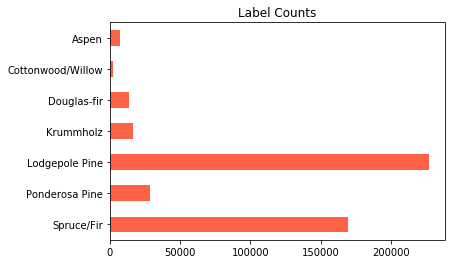

In [4]:
# assign label names and count label frequencies
label_map = {0:'Spruce/Fir', 1:'Lodgepole Pine', 2:'Ponderosa Pine', 3:'Cottonwood/Willow', 
             4:'Aspen', 5:'Douglas-fir', 6:'Krummholz'}
label_counts = pd.DataFrame(data=train_labels)[0].map(label_map).value_counts(sort=False).sort_index(ascending=False)
label_counts.plot('barh', color='tomato', title='Label Counts')

We can see that some forest cover types are much more common than others. Lodgepole Pine and Spruce/Fir are both well represented. Some labels, such as Cottonwood/Willow, are extremely rare. Later in this example notebook, we'll see how to fine-tune the algorithm depending on how important these rare categories are for our use case. But first we'll train with the defaults for the best all-around model.

### Training a classifier using the Amazon SageMaker Python SDK
We'll use the high-level estimator class `LinearLearner` to instantiate our training job and inference endpoint. For an example using the Python SDK's generic `Estimator` class, take a look at this previous [example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/scientific_details_of_algorithms/linear_learner_class_weights_loss_functions/linear_learner_class_weights_loss_functions.ipynb). The generic Python SDK estimator offers some more control options, but the high-level estimator is more succinct and has some advantages. One is that we don't need to specify the location of the algorithm container we want to use for training. It will pick up the latest version of the linear learner algorithm. Another advantage is that some code errors will be surfaced before a training cluster is spun up, rather than after. For example, if we try to pass `n_classes=7` instead of the correct `num_classes=7`, then the high-level estimator will fail immediately, but the generic Python SDK estimator will spin up a cluster before failing.

In [5]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# instantiate the LinearLearner estimator object
multiclass_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='multiclass_classifier',
                                               num_classes=7)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


Linear learner accepts training data in protobuf or csv content types, and accepts inference requests in protobuf, csv, or json content types. Training data have features and ground-truth labels, while the data in an inference request has only features. In a production pipeline, we recommend converting the data to the Amazon SageMaker protobuf format and storing it in S3. However, to get up and running quickly, we provide a convenience method `record_set` for converting and uploading  when the dataset is small enough to fit in local memory. It accepts `numpy` arrays like the ones we already have, so we'll use it here. The `RecordSet` object will keep track of the temporary S3 location of our data.

In [6]:
# wrap data in RecordSet objects
train_records = multiclass_estimator.record_set(train_features, train_labels, channel='train')
val_records = multiclass_estimator.record_set(val_features, val_labels, channel='validation')
test_records = multiclass_estimator.record_set(test_features, test_labels, channel='test')

In [7]:
# start a training job
multiclass_estimator.fit([train_records, val_records, test_records])

INFO:sagemaker:Creating training-job with name: linear-learner-2019-04-25-15-01-16-749


2019-04-25 15:01:17 Starting - Starting the training job...
2019-04-25 15:01:19 Starting - Launching requested ML instances......
2019-04-25 15:02:30 Starting - Preparing the instances for training......
2019-04-25 15:03:36 Downloading - Downloading input data...
2019-04-25 15:04:13 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[04/25/2019 15:04:15 INFO 140169155405632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7196277428988753, "sum": 0.7196277428988753, "min": 0.7196277428988753}}, "EndTime": 1556204678.166599, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1556204678.166513}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9234325578623804, "sum": 0.9234325578623804, "min": 0.9234325578623804}}, "EndTime": 1556204678.16671, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1556204678.166692}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7092250238615891, "sum": 0.7092250238615891, "min": 0.7092250238615891}}, "EndTime": 1556204678.166762, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1556

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7026583904397898, "sum": 0.7026583904397898, "min": 0.7026583904397898}}, "EndTime": 1556204702.175313, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1556204702.17525}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9177241080711628, "sum": 0.9177241080711628, "min": 0.9177241080711628}}, "EndTime": 1556204702.175405, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1556204702.175386}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6660722614156789, "sum": 0.6660722614156789, "min": 0.6660722614156789}}, "EndTime": 1556204702.175465, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1556

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7012267167979274, "sum": 0.7012267167979274, "min": 0.7012267167979274}}, "EndTime": 1556204725.480412, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1556204725.480351}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9154503553982438, "sum": 0.9154503553982438, "min": 0.9154503553982438}}, "EndTime": 1556204725.480501, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1556204725.480482}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6565769871678846, "sum": 0.6565769871678846, "min": 0.6565769871678846}}, "EndTime": 1556204725.480568, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 155

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7006389058869461, "sum": 0.7006389058869461, "min": 0.7006389058869461}}, "EndTime": 1556204748.884606, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1556204748.884544}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9135136167592016, "sum": 0.9135136167592016, "min": 0.9135136167592016}}, "EndTime": 1556204748.88469, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1556204748.884676}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6531938131924333, "sum": 0.6531938131924333, "min": 0.6531938131924333}}, "EndTime": 1556204748.884747, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1556

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7003863209691541, "sum": 0.7003863209691541, "min": 0.7003863209691541}}, "EndTime": 1556204772.266169, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1556204772.266107}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9119636271246548, "sum": 0.9119636271246548, "min": 0.9119636271246548}}, "EndTime": 1556204772.266252, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1556204772.266238}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6517735398391198, "sum": 0.6517735398391198, "min": 0.6517735398391198}}, "EndTime": 1556204772.266306, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 155

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7002390423478752, "sum": 0.7002390423478752, "min": 0.7002390423478752}}, "EndTime": 1556204795.791274, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1556204795.79121}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9106472283725081, "sum": 0.9106472283725081, "min": 0.9106472283725081}}, "EndTime": 1556204795.791364, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1556204795.791345}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6511148654016955, "sum": 0.6511148654016955, "min": 0.6511148654016955}}, "EndTime": 1556204795.791454, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1556

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7001702290239005, "sum": 0.7001702290239005, "min": 0.7001702290239005}}, "EndTime": 1556204819.059979, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1556204819.059917}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9095504843613197, "sum": 0.9095504843613197, "min": 0.9095504843613197}}, "EndTime": 1556204819.060061, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1556204819.060047}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6507833816265238, "sum": 0.6507833816265238, "min": 0.6507833816265238}}, "EndTime": 1556204819.060118, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 155

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7001352207578462, "sum": 0.7001352207578462, "min": 0.7001352207578462}}, "EndTime": 1556204842.431047, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1556204842.430946}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9086269746977708, "sum": 0.9086269746977708, "min": 0.9086269746977708}}, "EndTime": 1556204842.431141, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1556204842.431122}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6506088577796673, "sum": 0.6506088577796673, "min": 0.6506088577796673}}, "EndTime": 1556204842.431203, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 155

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7001223845646299, "sum": 0.7001223845646299, "min": 0.7001223845646299}}, "EndTime": 1556204865.706665, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1556204865.706603}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9078530625968144, "sum": 0.9078530625968144, "min": 0.9078530625968144}}, "EndTime": 1556204865.706746, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1556204865.706731}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6505133481518975, "sum": 0.6505133481518975, "min": 0.6505133481518975}}, "EndTime": 1556204865.706812, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 155


2019-04-25 15:07:54 Uploading - Uploading generated training model
2019-04-25 15:07:54 Completed - Training job completed
Billable seconds: 259


## Multiclass classification metrics

Now that we have a trained model, we want to make predictions and evaluate model performance on our test set. For that we'll need to deploy a model hosting endpoint to accept inference requests using the estimator API:

In [8]:
# deploy a model hosting endpoint
multiclass_predictor = multiclass_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2019-04-25-15-08-31-371
INFO:sagemaker:Creating endpoint with name linear-learner-2019-04-25-15-01-16-749


----------------------------------------------------------------------------------------!

We'll add a convenience function for parsing predictions and evaluating model metrics. It will feed test features to the endpoint and receive predicted test labels. To evaluate the models we create, we'll capture predicted test labels and compare them to actuals using some common multiclass classification metrics. As mentioned earlier, we're extracting the `predicted_label` from each response payload. That's the class with the highest predicted probability. We'll get one class label per example. To get a vector of seven probabilities for each example (the predicted probability for each class) , we would extract the `score` from the response payload. Details of linear learner's response format are in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/LL-in-formats.html).

In [9]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.722


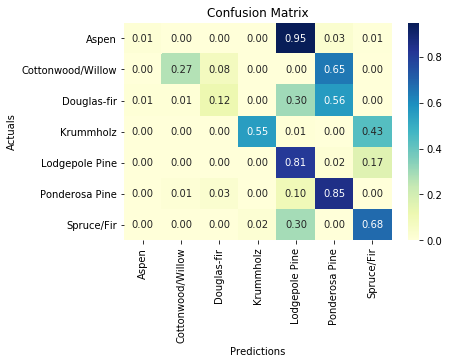

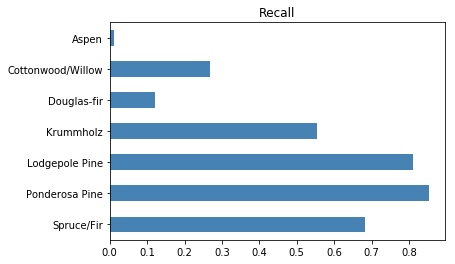

In [10]:
# evaluate metrics of the model trained with default hyperparameters
evaluate_metrics(multiclass_predictor, test_features, test_labels)

The first metric reported is accuracy. Accuracy for multiclass classification means the same thing as it does for binary classification: the percent of predicted labels which match ground-truth labels. Our model predicts the right type of forest cover over 72% of the time. 

Next we see the confusion matrix and a plot of class recall for each label. Recall is a binary classification metric which is also useful in the multiclass setting. It measures the model's accuracy when the true label belongs to the first class, the second class, and so on. If we average the recall values across all classes, we get a metric called *macro recall*, which you can find reported in the algorithm logs. You'll also find *macro precision* and *macro f-score*, which are constructed the same way.

The recall achieved by our model varies widely among the classes. Recall is high for the most common labels, but is very poor for the rarer labels like Aspen or Cottonwood/Willow. Our predictions are right most of the time, but when the true cover type is a rare one like Aspen or Cottonwood/Willow, our model tends to predict wrong.

A confusion matrix is a tool for visualizing the performance of a multiclass model. It has entries for all possible combinations of correct and incorrect predictions, and shows how often each one was made by our model. It has been row-normalized: each row sums to one, so that entries along the diagonal correspond to recall. For example, the first row shows that when the true label is Aspen, the model predicts correctly only 1% of the time, and incorrectly predicts Lodgepole Pine 95% of the time. The second row shows that when the true forest cover type is Cottonwood/Willow, the model has 27% recall, and incorrectly predicts Ponderosa Pine 65% of the time. If our model had 100% accuracy, and therefore 100% recall in every class, then all of the predictions would fall along the diagonal of the confusion matrix. 

It's normal that the model performs poorly on very rare classes. It doesn't have much data to learn about them, and it was optimized for global performance. By default, linear learner uses the softmax loss function, which optimizes the likelihood of a multinomial distribution. It's similar in principle to optimizing global accuracy. 

But what if one of the rare class labels is especially important to our use case? For example, maybe we're predicting customer outcomes, and one of the potential outcomes is a dissatisfied customer. Hopefully that's a rare outcome, but it might be one that's especially important to predict and act on quickly. In that case, we might be able to sacrifice a bit of overall accuracy in exchange for much improved recall on rare classes. Let's see how.

## Training with balanced class weights

Class weights alter the loss function optimized by the linear learner algorithm. They put more weight on rarer classes so that the importance of each class is equal. Without class weights, each example in the training set is treated equally. If 80% of those examples have labels from one overrepresented class, that class will get 80% of the attention during model training. With balanced class weights, each class has the same amount of influence during training.

With balanced class weights turned on, linear learner will count label frequencies in your training set. This is done efficiently using a sample of the training set. The weights will be the inverses of the frequencies. A label that's present in 1/3 of the sampled training examples will get a weight of 3, and a rare label that's present in only 0.001% of the examples will get a weight of 100,000. A label that's not present at all in the sampled training examples will get a weight of 1,000,000 by default. To turn on class weights, use the `balance_multiclass_weights` hyperparameter:

In [11]:
# instantiate the LinearLearner estimator object
balanced_multiclass_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                                        train_instance_count=1,
                                                        train_instance_type='ml.m4.xlarge',
                                                        predictor_type='multiclass_classifier',
                                                        num_classes=7,
                                                        balance_multiclass_weights=True)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


In [12]:
# start a training job
balanced_multiclass_estimator.fit([train_records, val_records, test_records])

INFO:sagemaker:Creating training-job with name: linear-learner-2019-04-25-15-16-07-190


2019-04-25 15:16:07 Starting - Starting the training job...
2019-04-25 15:16:09 Starting - Launching requested ML instances......
2019-04-25 15:17:16 Starting - Preparing the instances for training...
2019-04-25 15:18:02 Downloading - Downloading input data...
2019-04-25 15:18:11 Training - Downloading the training image...
2019-04-25 15:18:55 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[04/25/2019 15:18:57 INFO 139981302499136] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.2536400304333917, "sum": 2.2536400304333917, "min": 2.2536400304333917}}, "EndTime": 1556205563.227119, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1556205563.227055}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.77347879712335, "sum": 2.77347879712335, "min": 2.77347879712335}}, "EndTime": 1556205563.227209, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1556205563.227194}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.297210075378418, "sum": 2.297210075378418, "min": 2.297210075378418}}, "EndTime": 1556205563.227268, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1556205563.227255}

#

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.1191141975665913, "sum": 2.1191141975665913, "min": 2.1191141975665913}}, "EndTime": 1556205590.308068, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1556205590.308007}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.7370499504352437, "sum": 2.7370499504352437, "min": 2.7370499504352437}}, "EndTime": 1556205590.308157, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1556205590.308138}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.0272467133094523, "sum": 2.0272467133094523, "min": 2.0272467133094523}}, "EndTime": 1556205590.308221, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1556205590.3

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.0990273845277985, "sum": 2.0990273845277985, "min": 2.0990273845277985}}, "EndTime": 1556205616.768588, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1556205616.768527}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.722649586118501, "sum": 2.722649586118501, "min": 2.722649586118501}}, "EndTime": 1556205616.768669, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1556205616.768655}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9606223002466663, "sum": 1.9606223002466663, "min": 1.9606223002466663}}, "EndTime": 1556205616.768726, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1556205616.7687

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.091818443561422, "sum": 2.091818443561422, "min": 2.091818443561422}}, "EndTime": 1556205643.382443, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1556205643.382383}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.710412169883991, "sum": 2.710412169883991, "min": 2.710412169883991}}, "EndTime": 1556205643.382531, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1556205643.382512}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9350167573073815, "sum": 1.9350167573073815, "min": 1.9350167573073815}}, "EndTime": 1556205643.382595, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1556205643.382578}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.0888136415152716, "sum": 2.0888136415152716, "min": 2.0888136415152716}}, "EndTime": 1556205669.789361, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1556205669.789301}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.7000513058366447, "sum": 2.7000513058366447, "min": 2.7000513058366447}}, "EndTime": 1556205669.789442, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1556205669.789428}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9237506695451407, "sum": 1.9237506695451407, "min": 1.9237506695451407}}, "EndTime": 1556205669.789499, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1556205669.7

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.08752954048946, "sum": 2.08752954048946, "min": 2.08752954048946}}, "EndTime": 1556205696.387999, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1556205696.387917}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.691235636744006, "sum": 2.691235636744006, "min": 2.691235636744006}}, "EndTime": 1556205696.3881, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1556205696.388083}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9180708486622777, "sum": 1.9180708486622777, "min": 1.9180708486622777}}, "EndTime": 1556205696.38815, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1556205696.388138}

#met

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.086993860968228, "sum": 2.086993860968228, "min": 2.086993860968228}}, "EndTime": 1556205723.011724, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1556205723.011645}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.6837000727160225, "sum": 2.6837000727160225, "min": 2.6837000727160225}}, "EndTime": 1556205723.011827, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1556205723.011807}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9150425001999427, "sum": 1.9150425001999427, "min": 1.9150425001999427}}, "EndTime": 1556205723.011892, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1556205723.0118

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.0866962238180227, "sum": 2.0866962238180227, "min": 2.0866962238180227}}, "EndTime": 1556205749.722583, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1556205749.722519}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.677240921546673, "sum": 2.677240921546673, "min": 2.677240921546673}}, "EndTime": 1556205749.722668, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1556205749.722653}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.913446737618282, "sum": 1.913446737618282, "min": 1.913446737618282}}, "EndTime": 1556205749.72273, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1556205749.722713}


#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.0865724984530747, "sum": 2.0865724984530747, "min": 2.0865724984530747}}, "EndTime": 1556205776.43453, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1556205776.434449}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.671686688127189, "sum": 2.671686688127189, "min": 2.671686688127189}}, "EndTime": 1556205776.43463, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1556205776.434613}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9126604374852674, "sum": 1.9126604374852674, "min": 1.9126604374852674}}, "EndTime": 1556205776.434681, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1556205776.434669

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.0865623276809164, "sum": 2.0865623276809164, "min": 2.0865623276809164}}, "EndTime": 1556205803.076253, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1556205803.076189}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.6668846840694034, "sum": 2.6668846840694034, "min": 2.6668846840694034}}, "EndTime": 1556205803.076347, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1556205803.076326}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.912281546757139, "sum": 1.912281546757139, "min": 1.912281546757139}}, "EndTime": 1556205803.076631, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1556205803.0766

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.0865532602770576, "sum": 2.0865532602770576, "min": 2.0865532602770576}}, "EndTime": 1556205829.701901, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1556205829.701838}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.6627215686666554, "sum": 2.6627215686666554, "min": 2.6627215686666554}}, "EndTime": 1556205829.702036, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1556205829.701974}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9120532823759935, "sum": 1.9120532823759935, "min": 1.9120532823759935}}, "EndTime": 1556205829.702109, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 155620582

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.086544079484611, "sum": 2.086544079484611, "min": 2.086544079484611}}, "EndTime": 1556205856.33531, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1556205856.335243}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.6591095465298356, "sum": 2.6591095465298356, "min": 2.6591095465298356}}, "EndTime": 1556205856.335401, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1556205856.335383}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9119179358646787, "sum": 1.9119179358646787, "min": 1.9119179358646787}}, "EndTime": 1556205856.335459, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1556205856.33

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.086534819767393, "sum": 2.086534819767393, "min": 2.086534819767393}}, "EndTime": 1556205883.035106, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1556205883.035018}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.65595171750825, "sum": 2.65595171750825, "min": 2.65595171750825}}, "EndTime": 1556205883.035197, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1556205883.035182}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.9118431599057955, "sum": 1.9118431599057955, "min": 1.9118431599057955}}, "EndTime": 1556205883.035259, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1556205883.035242}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.086525518483129, "sum": 2.086525518483129, "min": 2.086525518483129}}, "EndTime": 1556205909.84869, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1556205909.848605}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 2.653188641778354, "sum": 2.653188641778354, "min": 2.653188641778354}}, "EndTime": 1556205909.848795, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1556205909.848778}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 1.911804937165359, "sum": 1.911804937165359, "min": 1.911804937165359}}, "EndTime": 1556205909.849048, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1556205909.849028}



2019-04-25 15:25:23 Uploading - Uploading generated training model
2019-04-25 15:25:23 Completed - Training job completed
Billable seconds: 441


In [13]:
# deploy a model hosting endpoint
balanced_multiclass_predictor = balanced_multiclass_estimator.deploy(initial_instance_count=1, 
                                                                     instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2019-04-25-15-25-53-765
INFO:sagemaker:Creating endpoint with name linear-learner-2019-04-25-15-16-07-190


-----------------------------------------------------------------------------!

Accuracy: 0.592


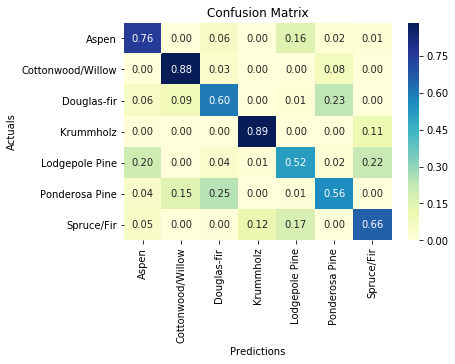

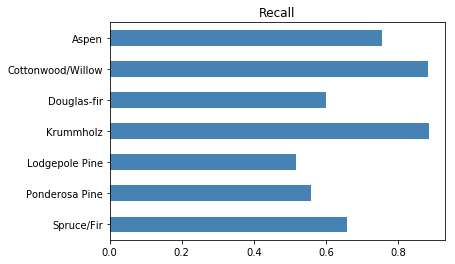

In [14]:
# evaluate metrics of the model trained with balanced class weights
evaluate_metrics(balanced_multiclass_predictor, test_features, test_labels)

The difference made by class weights is immediately clear from the confusion matrix. The predictions now line up nicely along the diagonal of the matrix, meaning predicted labels match actual labels. Recall for the rare Aspen class was only 1%, but now recall for every class is above 50%. That's a huge improvement in our ability to predict rare labels correctly.

But remember that the confusion matrix has each row normalized to sum to 1. Visually, we've given each class equal weight in our diagnostic tool. That emphasizes the gains we've made in rare classes, but it de-emphasizes the price we'll pay in terms of predicting more common classes. Recall for the most common class, Lodgepole Pine, has gone from 81% to 52%. For that reason, overall accuracy also decreased from 72% to 59%. To decide whether to use balanced class weights for your application, consider the business impact of making errors in common cases and how it compares to the impact of making errors in rare cases.

#### Deleting the hosting endpoints

Finally, we'll delete the hosting endpoints. The machines used for training spin down automatically, but the hosting endpoints remain active until you shut them down.

In [15]:
# delete endpoints
multiclass_predictor.delete_endpoint()
balanced_multiclass_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2019-04-25-15-01-16-749
INFO:sagemaker:Deleting endpoint with name: linear-learner-2019-04-25-15-01-16-749
INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2019-04-25-15-16-07-190
INFO:sagemaker:Deleting endpoint with name: linear-learner-2019-04-25-15-16-07-190


## Conclusion

In this example notebook, we introduced the new multiclass classification feature of the Amazon SageMaker linear learner algorithm. We showed how to fit a multiclass model using the convenient high-level estimator API, and how to evaluate and interpret model metrics. We also showed how to achieve higher recall for rare classes using linear learner's automatic class weights calculation. Try Amazon SageMaker and linear learner on your classification problems today!